In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

$$
\frac{\partial u}{\partial t} + a \frac{\partial u}{\partial x} = D \frac{\partial^2 u}{\partial x^2},
$$

Initial condition:

$$
u(x,0) = \frac{1}{\sigma_0 \sqrt{2 \pi}} \exp \left( -\frac{(x - \mu_0)^2}{2 \sigma_0^2} \right),
$$

In [3]:
# Phisical physiques
a = 1.0     # Vitesse d'advection
D = 0.1     # Coefficient de diffusion

# Domaine spatial
x_min = 0.0
x_max = 1.0
Nx = 100    # Nombre de points spatiaux
dx = (x_max - x_min) / (Nx - 1)
x = np.linspace(x_min, x_max, Nx)

# Domaine temporel
T = 5.0
dt = 0.0001  # Pas temps (critère CFL)
Nt = int(T / dt)
t = np.linspace(0, T, Nt)  # Coordonnées temporelles

CFL conditions:

**Advection :**
$$
\text{CFL}_a = \frac{a \Delta t}{\Delta x} \leq 1
$$

**Diffusion :**
$$
\text{CFL}_D = \frac{D \Delta t}{\Delta x^2} \leq 0.5
$$

In [4]:
# Vérification de la condition de stabilité (CFL)
CFL_a = a * dt / dx
CFL_D = D * dt / dx**2
print(f"CFL advection: {CFL_a}")
print(f"CFL diffusion: {CFL_D}")

# Vérification
if CFL_a > 1.0:
    print("Critère de stabilité advection pas respecté (CFL_a <= 1).")
if CFL_D > 0.5:
    print("Critère de stabilité diffusion pas respecté (CFL_D <= 0.5).")

CFL advection: 0.009899999999999999
CFL diffusion: 0.09801


In [5]:
def initial_condition(x, mu0, sigma0):
    return (1.0 / np.sqrt(2 * np.pi * sigma0**2)) * np.exp(- (x - mu0)**2 / (2 * sigma0**2))

In [6]:
# Model parameters
a = 1.0     # Advection speed
D = 0.1     # Diffusion coefficient
L = 10.0    # Domain length
T = 2.0     # Total simulation time

# Position and time grid
x = np.linspace(0, L, 500)
t_values = np.linspace(0, T, 2)  # Choose 5 moments to display

# Different initial conditions for mean and variance
initial_conditions = [
    {'mu_0': 2.0, 'sigma_0': 0.5},
    {'mu_0': 5.0, 'sigma_0': 1.0},
    {'mu_0': 8.0, 'sigma_0': 1.5}
]

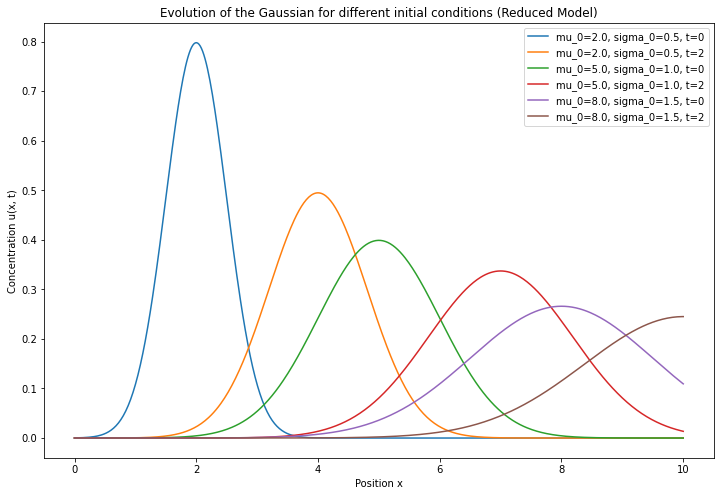

In [ ]:
# Display the evolution for each initial condition
plt.figure(figsize=(12, 8))
for idx, cond in enumerate(initial_conditions):
    mu_0 = cond['mu_0']
    sigma_0 = cond['sigma_0']
    
    for t in t_values:
        # Calculation of mean and variance at time t
        mu_t = mu_0 + a * t
        sigma_t_sq = sigma_0**2 + 2 * D * t
        u_xt = (1 / np.sqrt(2 * np.pi * sigma_t_sq)) * np.exp(-((x - mu_t)**2) / (2 * sigma_t_sq))
        
        # Plot the Gaussian
        plt.plot(x, u_xt, label=f'mu_0={mu_0}, sigma_0={sigma_0}, t={t:.1g}')

# Graph formatting
plt.xlabel('Position x')
plt.ylabel('Concentration u(x, t)')
plt.legend(loc = "best")
plt.title("Evolution of the Gaussian for different initial conditions (Reduced Model)")
# Save the figure
plt.savefig('evolution_gaussian.png')

plt.show()

In [8]:
# Initial conditions
def initial_condition(x, mu, sigma):
    sqrt_2pi = torch.sqrt(torch.tensor(2 * torch.pi, dtype=x.dtype, device=x.device))
    return torch.exp(-((x - mu) ** 2) / (2 * sigma ** 2)) / (sigma * sqrt_2pi)


In [9]:
# Solve the advection-diffusion equation
def solve_advection_diffusion(n_points, mu0, sigma0, a, D, t):
    x = torch.linspace(0, 1, n_points)
    mu_t = torch.clamp(mu0 + a * t, min=0.0, max=1.0)
    sigma_t = torch.sqrt(sigma0**2 + 2 * D * t)
    u_t = initial_condition(x, mu_t, sigma_t)
    return x, u_t

In [10]:
# Generate the dataset
def generate_project_dataset(n_samples, n_points, a, D, t_values):
    mu_values = torch.linspace(0.2, 0.8, n_samples)
    sigma_values = torch.linspace(0.05, 0.3, n_samples)
    solutions = []

    for mu, sigma in zip(mu_values, sigma_values):
        for t in t_values:
            _, u_t = solve_advection_diffusion(n_points, mu, sigma, a, D, t)
            solutions.append(u_t)

    solutions = torch.stack(solutions)  # stack the solutions
    params = torch.stack([mu_values.repeat(len(t_values)), sigma_values.repeat(len(t_values)), t_values.clone().detach().repeat(n_samples)], dim=1)  # Paramètres

    return params, solutions

In [11]:
# Autoencodeur
class ConvAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=5, stride=2, padding=2),
            nn.ELU(),
            nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.ELU(),
            nn.Conv1d(128, 256, kernel_size=5, stride=2, padding=2),
            nn.ELU(),
            nn.Flatten(),
            nn.Linear(256 * (input_dim // 8), 512),
            nn.ELU(),
            nn.Linear(512, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ELU(),
            nn.Linear(512, 256 * (input_dim // 8)),
            nn.ELU(),
            nn.Unflatten(1, (256, input_dim // 8)),
            nn.ConvTranspose1d(256, 128, kernel_size=5, stride=2, 
                               padding=2, output_padding=1),
            nn.ELU(),
            nn.ConvTranspose1d(128, 64, kernel_size=5, stride=2, 
                               padding=2, output_padding=1),
            nn.ELU(),
            nn.ConvTranspose1d(64, 1, kernel_size=5, stride=2, 
                               padding=2, output_padding=1)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon


In [12]:
# generate the dataset
n_samples = 256
n_points = 256
a = 1.0
D = 0.1
t_values = torch.linspace(0, 0.3, 5)  # take snapshots every 5 times up to 0.3
params, solutions = generate_project_dataset(n_samples, n_points, a, D, t_values)

solutions -= solutions[:, 0:1] 

# Normalisation
mean = solutions.mean()
std = solutions.std()
solutions = (solutions - mean) / std

# Prepare the dataset and dataloader
solutions = solutions.unsqueeze(1)  # add channel dimension
dataset = TensorDataset(solutions, solutions)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Model parameters
latent_dim = 2
autoencoder = ConvAutoencoder(n_points, latent_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
n_epochs = 300

In [13]:
# Impression of the parameters
print(f"Coefficient de diffusion (D): {D}")
print(f"Temps correspondant au premier snapshot: {t_values[0].item()}")
print(f"Temps correspondant au dernier snapshot: {t_values[-1].item()}")
print(f"Nombre de snapshots après échantillonnage tous les {len(t_values)} temps: {len(t_values) * n_samples}")

Coefficient de diffusion (D): 0.1
Temps correspondant au premier snapshot: 0.0
Temps correspondant au dernier snapshot: 0.30000001192092896
Nombre de snapshots après échantillonnage tous les 5 temps: 1280


In [14]:
# Training with random sampling of snapshots
for epoch in range(n_epochs):
    for batch in dataloader:
        optimizer.zero_grad()
        x, _ = batch
        # Subsample a random subset of snapshots
        idx = torch.randperm(x.size(0))[:32]  # Randomly select 32 snapshots
        x_sample = x[idx]
        x_recon = autoencoder(x_sample)
        weight = 1.0 + torch.abs(x_sample - x_recon)  # Dynamic weighting
        loss = (weight * (x_sample - x_recon) ** 2).mean()
        loss.backward()
        optimizer.step()
    scheduler.step()
    if (epoch + 1) % 10 == 0:
        print(f"Époque {epoch + 1}/{n_epochs}, Perte: {loss.item():.6g}")


Époque 10/300, Perte: 0.00578343
Époque 20/300, Perte: 0.00136051
Époque 30/300, Perte: 0.000915181
Époque 40/300, Perte: 0.000477952
Époque 50/300, Perte: 0.000570801
Époque 60/300, Perte: 0.00042811
Époque 70/300, Perte: 0.000459363
Époque 80/300, Perte: 0.00043099
Époque 90/300, Perte: 0.000268816
Époque 100/300, Perte: 0.000250457
Époque 110/300, Perte: 0.00013086
Époque 120/300, Perte: 0.00013602
Époque 130/300, Perte: 0.000135948
Époque 140/300, Perte: 0.00022025
Époque 150/300, Perte: 0.000244979
Époque 160/300, Perte: 0.000298346
Époque 170/300, Perte: 0.000315272
Époque 180/300, Perte: 0.000129138
Époque 190/300, Perte: 9.38263e-05
Époque 200/300, Perte: 0.000103042
Époque 210/300, Perte: 0.000197769
Époque 220/300, Perte: 9.10456e-05
Époque 230/300, Perte: 0.000100375
Époque 240/300, Perte: 0.000297508
Époque 250/300, Perte: 0.000101348
Époque 260/300, Perte: 7.75408e-05
Époque 270/300, Perte: 5.59691e-05
Époque 280/300, Perte: 0.000128218
Époque 290/300, Perte: 9.246e-05
Épo

In [15]:
# Random parameters for validation
params, u_exact = generate_project_dataset(5, n_points, a, D, t_values)
u_exact -= u_exact[:, 0:1]  # 
u_exact = (u_exact - mean) / std  # Normalisation

# Reconstruction
u_reconstructed = autoencoder(u_exact[:, None, :]).squeeze().detach()
u_reconstructed = u_reconstructed * std + mean 

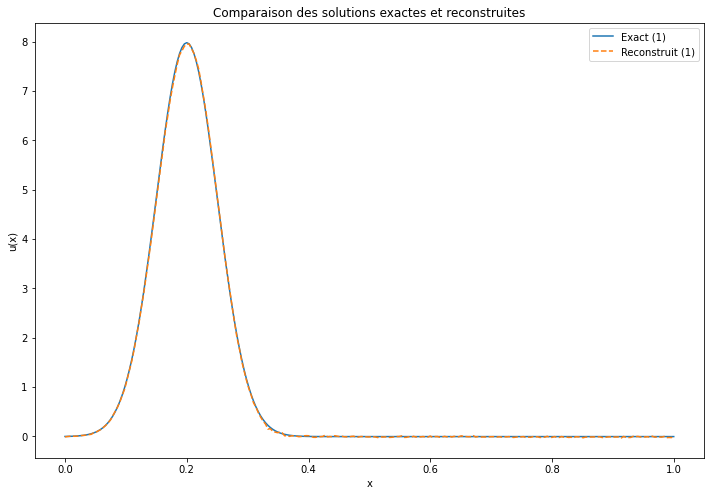

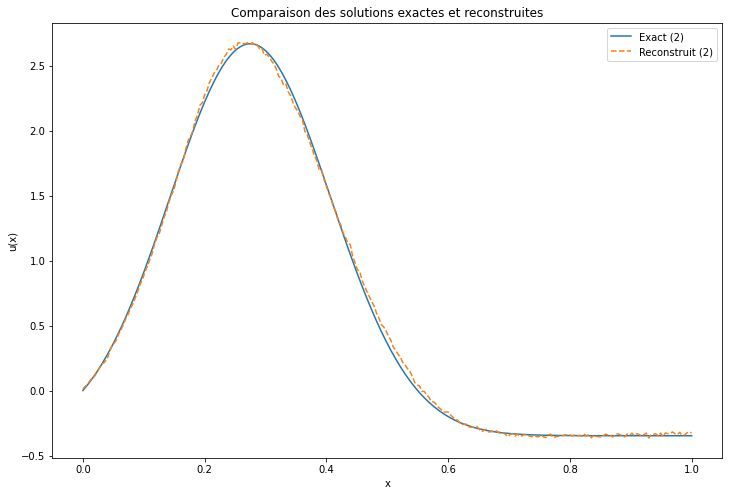

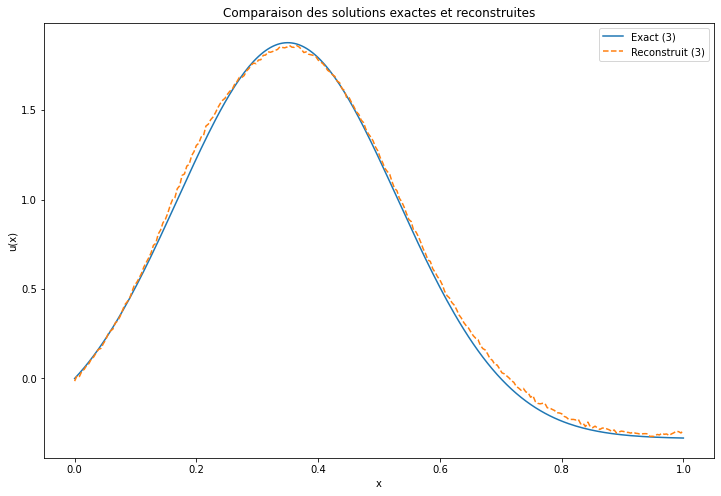

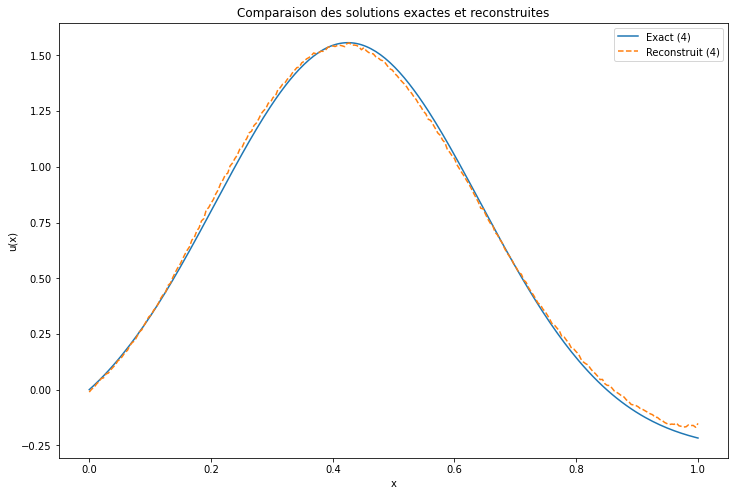

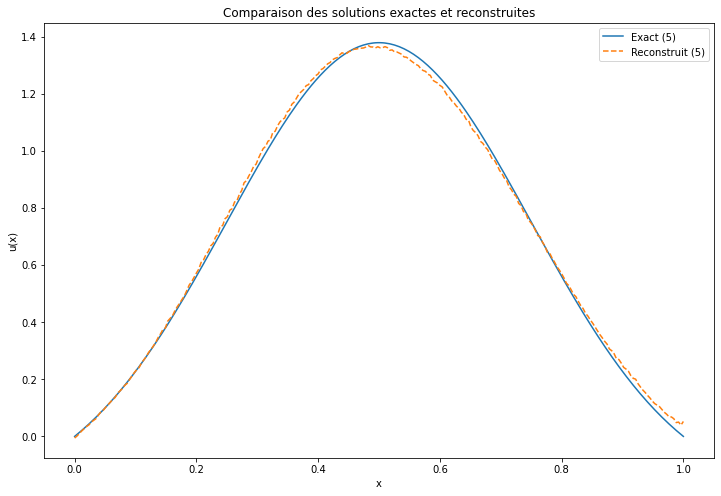

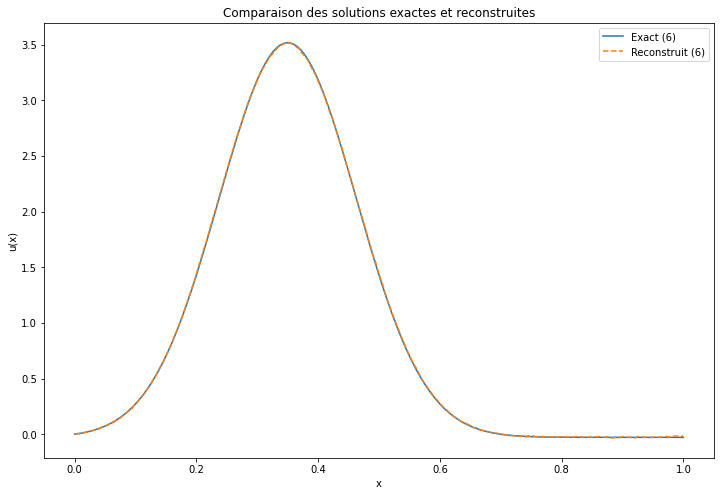

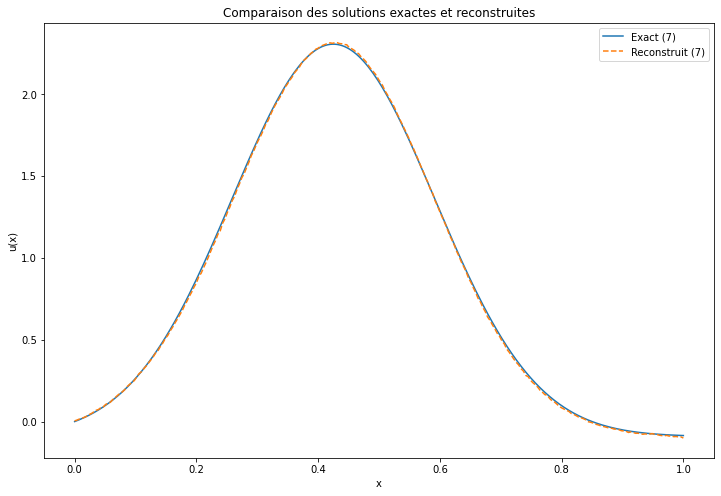

In [16]:
# Plot the exact and reconstructed solutions
u_exact = u_exact * std + mean 
x = torch.linspace(0, 1, n_points)
# plt.figure(figsize=(12, 8))
for i in range(7):
    plt.figure(figsize=(12, 8))
    plt.plot(x, u_exact[i, :], label=f"Exact ({i+1})")
    plt.plot(x, u_reconstructed[i, :], label=f"Reconstruit ({i+1})", linestyle="--")
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("u(x)")
    plt.title("Comparaison des solutions exactes et reconstruites")
    plt.show()

In [20]:
import os
import math
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

###########################
# 1) Imported Autoencoder (same structure as trained)
###########################
class ConvAutoencoder(nn.Module):
    def __init__(self, input_dim=100, latent_dim=2):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=5, stride=2, padding=2),  # (1, 100) -> (32, 50)
            nn.ELU(),
            nn.Conv1d(32, 64, kernel_size=5, stride=2, padding=2),  # (32, 50) -> (64, 25)
            nn.ELU(),
            nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2),  # (64, 25) -> (128, 13)
            nn.ELU(),
            nn.Flatten(),  # (128, 13) -> 1664
            nn.Linear(128*13, 128),
            nn.ELU(),
            nn.Linear(128, latent_dim),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ELU(),
            nn.Linear(128, 128 * 13),
            nn.ELU(),
            nn.Unflatten(1, (128, 13)),  # (128, 13)
            nn.ConvTranspose1d(128, 64, kernel_size=5, stride=2, padding=2, output_padding=1),  # (128,13) -> (64,26)
            nn.ELU(),
            nn.ConvTranspose1d(64, 32, kernel_size=5, stride=2, padding=2, output_padding=1),   # (64,26) -> (32,52)
            nn.ELU(),
            nn.ConvTranspose1d(32, 1, kernel_size=5, stride=2, padding=4, output_padding=1),    # (32,52) -> (1,100)
        )
    
    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

###########################
# 2) SINDy-like
###########################
def true_function_u(x, mu_true, sigma_true, theta_true):
    t1, t2, t3, t4, t5, t6 = theta_true
    term_gauss = t4 * torch.exp(-0.5 * ((x - mu_true) / sigma_true)**2)
    term_sin   = t5 * torch.sin(2.0 * math.pi * x)
    term_mu2   = t6 * torch.exp(-torch.tensor(mu_true**2))
    return t1 + t2 * x + t3 * x**2 + term_gauss + term_sin + term_mu2

def generate_data(n_samples=100, noise=0.01, mu0=0.3, sigma0=0.1):
    # Assuming Nx=100 corresponds to the autoencoder
    theta_true = [0.5, 1.0, -2.0, 0.5, 0.5, 0.5]
    x = torch.linspace(0, 1, n_samples)
    U_clean = true_function_u(x, mu0, sigma0, theta_true)
    U_noisy = U_clean + noise * torch.randn_like(x)
    return x, U_noisy, mu0, sigma0, theta_true

class ParamU(nn.Module):
    def __init__(self):
        super().__init__()
        self.theta = nn.Parameter(torch.zeros(6))
        self.mu = nn.Parameter(torch.tensor(0.0))
        self.log_sigma = nn.Parameter(torch.tensor(-2.0))
    
    def forward(self, x):
        t1, t2, t3, t4, t5, t6 = self.theta
        mu = self.mu
        sigma = torch.exp(self.log_sigma)
        gauss = t4 * torch.exp(-0.5 * ((x - mu) / sigma)**2)
        sinus = t5 * torch.sin(2.0 * math.pi * x)
        mu2   = t6 * torch.exp(-mu**2)
        return t1 + t2 * x + t3 * x**2 + gauss + sinus + mu2

def train_model_sindy(model, x, U_obs, lr=1e-2, n_epochs=1000,
                     alpha_l1=1e-3, threshold=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    loss_history = []
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        U_pred = model(x)
        mse = criterion(U_pred, U_obs)
        l1  = model.theta.abs().sum()
        loss = mse + alpha_l1 * l1
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            mask = (model.theta.abs() < threshold)
            model.theta[mask] = 0.0
        loss_history.append(loss.item())
    return loss_history

def plain_expression(theta, mu, sigma):
    t1, t2, t3, t4, t5, t6 = theta
    return (
        f"{t1:.2f} + {t2:.2f}*x + {t3:.2f}*x^2 + "
        f"{t4:.2f}*exp(-0.5*((x - {mu:.2f})/{sigma:.2f})**2) + "
        f"{t5:.2f}*sin(2*pi*x) + "
        f"{t6:.2f}*exp(-({mu:.2f})**2)"
    )

###########################
# 3) Function to Load the Autoencoder
###########################

def load_pretrained_autoencoder(checkpoint_path="autoencoder_weights.pth", 
                                input_dim=100, latent_dim=2, device="cpu"):
    autoencoder = ConvAutoencoder(input_dim=input_dim, latent_dim=latent_dim).to(device)
    if os.path.exists(checkpoint_path):
        state_dict = torch.load(checkpoint_path, map_location=device)
        try:
            autoencoder.load_state_dict(state_dict)
            print(f"[INFO] Poids du modèle chargés depuis '{checkpoint_path}'.")
        except RuntimeError as e:
            print(f"[ERROR] Échec du chargement des poids : {e}")
            print("[INFO] Entraînement de l'autoencodeur...")
            train_autoencoder(autoencoder, device)
            torch.save(autoencoder.state_dict(), checkpoint_path)
            print(f"[INFO] Autoencodeur entraîné et poids sauvegardés dans '{checkpoint_path}'.")
    else:
        print(f"[WARNING] Aucun poids trouvés à '{checkpoint_path}'. Entraînement de l'autoencodeur...")
        train_autoencoder(autoencoder, device)
        torch.save(autoencoder.state_dict(), checkpoint_path)
        print(f"[INFO] Autoencodeur entraîné et poids sauvegardés dans '{checkpoint_path}'.")
    autoencoder.eval()
    return autoencoder

def train_autoencoder(autoencoder, device, epochs=300, learning_rate=1e-3):
    """
    Function to train the autoencoder.
    """
    optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    
    autoencoder.train()
    for epoch in range(epochs):
        # Generate dummy training data
        inputs = torch.randn(32, 1, 100).to(device)  # batch_size=32, channels=1, length=100
        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        
        # if (epoch + 1) % 10 == 0:
        #     print(f"[TRAIN] Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")

###########################
# 4) Main Explore
###########################
def main():
    # Parameters
    device = "cpu"
    Nx = 100       # The exact 'input_dim' for which the autoencoder was trained
    latent_dim = 2

    # Create the directory for plots if necessary
    plots_dir = "plots"
    if not os.path.exists(plots_dir):
        os.makedirs(plots_dir)
        print(f"[INFO] Created directory '{plots_dir}' to save images.")
    
    # 1) Load the autoencoder
    autoencoder = load_pretrained_autoencoder(
        checkpoint_path="autoencoder_weights.pth",
        input_dim=Nx,  # corresponds to Nx=100
        latent_dim=latent_dim,
        device=device
    )
    encoder = autoencoder.encoder
    encoder.eval()

    # 2) Loop over mu0, sigma0
    mu0_list = [0.2, 0.3, 0.5]
    sigma0_list = [0.05, 0.1, 0.15]

    for mu0 in mu0_list:
        for sigma0 in sigma0_list:
            # Generate Nx=100 points data
            x, U_obs, _, _, _ = generate_data(n_samples=Nx, noise=0.01,
                                             mu0=mu0, sigma0=sigma0)

            # Format for the autoencoder => (batch=1, channel=1, Nx)
            data_ae = U_obs.unsqueeze(0).unsqueeze(0)  # shape=(1,1,100)

            with torch.no_grad():
                z = encoder(data_ae.to(device))  # => shape=(1, latent_dim)
            # print(f"Latent code z = {z.flatten().tolist()} for mu0={mu0}, sigma0={sigma0}")

            # Train a ParamU
            model = ParamU()
            train_model_sindy(model, x, U_obs, n_epochs=3000,
                              alpha_l1=5e-4, threshold=1e-3)

            # Extract learned parameters
            t_final = model.theta.detach().numpy()
            mu_est  = model.mu.item()
            sig_est = torch.exp(model.log_sigma).item()

            # Display expressions
            expr_true = plain_expression([0.5, 1.0, -2.0, 0.5, 0.5, 0.5], mu0, sigma0)
            expr_learned = plain_expression(t_final, mu_est, sig_est)

            print(f"\nmu0={mu0}, sigma0={sigma0}")
            print(f"True expression   : {expr_true}")
            print(f"Learned expression: {expr_learned}")

            # Plot
            x_plot = torch.linspace(0, 1, 200)
            with torch.no_grad():
                U_pred = model(x_plot)

            plt.figure()
            plt.scatter(x, U_obs, s=10, alpha=0.3, color='blue', label='Observed')
            plt.plot(x_plot, U_pred, 'r-', linewidth=1.5, label='Predicted')
            plt.title(f"mu0={mu0}, sigma0={sigma0}")
            plt.xlabel("x")
            plt.ylabel("u(x)")
            plt.legend()
            plt.grid(True)
            
            # Define the filename based on mu0 and sigma0
            filename = f"mu{mu0}_sigma{sigma0}.png"
            filepath = os.path.join(plots_dir, filename)
            
            # Save the figure
            plt.savefig(filepath)
            print(f"[INFO] Image saved to '{filepath}'.")
            
            # # Display the figure (optional)
            # plt.show()
            
            # Close the figure to free memory
            plt.close()

if __name__ == "__main__":
    main()

<ipython-input-20-c234ad4d9544>:116: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path, map_location=device)


[ERROR] Échec du chargement des poids : Error(s) in loading state_dict for ConvAutoencoder:
	Missing key(s) in state_dict: "encoder.2.weight", "encoder.2.bias", "encoder.9.weight", "encoder.9.bias", "decoder.2.weight", "decoder.2.bias", "decoder.5.weight", "decoder.5.bias", "decoder.9.weight", "decoder.9.bias". 
	Unexpected key(s) in state_dict: "encoder.10.weight", "encoder.10.bias", "encoder.11.weight", "encoder.11.bias", "encoder.11.running_mean", "encoder.11.running_var", "encoder.11.num_batches_tracked", "encoder.13.weight", "encoder.13.bias", "encoder.1.weight", "encoder.1.bias", "encoder.1.running_mean", "encoder.1.running_var", "encoder.1.num_batches_tracked", "encoder.3.weight", "encoder.3.bias", "encoder.4.running_mean", "encoder.4.running_var", "encoder.4.num_batches_tracked", "encoder.6.weight", "encoder.6.bias", "encoder.7.running_mean", "encoder.7.running_var", "encoder.7.num_batches_tracked", "decoder.10.weight", "decoder.10.bias", "decoder.11.weight", "decoder.11.bias",

In [22]:
import os
import math
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def plot_three_times(x, 
                    u0, uT2, uT,       # "original curves" for t=0, t=T/2, t=T
                    u0_rec, uT2_rec, uT_rec,  # "reconstructed curves"
                    mu0, sigma0):
    """
    Displays 3 subplots: t=0, t=T/2, t=T
    - On each subplot: "Original" in blue and "Reconstructed" in dashed red.
    - Overall title: f"Simulation: mu0={mu0}, sigma0={sigma0}"
    Returns the figure to be able to save it.
    """
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
    
    # First subplot (t=0)
    axes[0].plot(x, u0, 'b-', label="Original")
    axes[0].plot(x, u0_rec, 'r--', label="Reconstructed")
    axes[0].set_title("t = 0")
    axes[0].set_xlabel("x")
    axes[0].set_ylabel("u(x, t)")
    axes[0].legend()

    # Second subplot (t=T/2)
    axes[1].plot(x, uT2, 'b-')
    axes[1].plot(x, uT2_rec, 'r--')
    axes[1].set_title("t = T/2")
    axes[1].set_xlabel("x")

    # Third subplot (t=T)
    axes[2].plot(x, uT, 'b-')
    axes[2].plot(x, uT_rec, 'r--')
    axes[2].set_title("t = T")
    axes[2].set_xlabel("x")

    fig.suptitle(f"Simulation: mu0 = {mu0}, sigma0 = {sigma0}", fontsize=14)
    plt.tight_layout()
    return fig  # Returns the figure object

def true_function_u(x, mu_true, sigma_true, theta_true):
    t1, t2, t3, t4, t5, t6 = theta_true
    term_gauss = t4 * torch.exp(-0.5 * ((x - mu_true) / sigma_true)**2)
    term_sin   = t5 * torch.sin(2.0 * math.pi * x)
    term_mu2   = t6 * torch.exp(-torch.tensor(mu_true**2))
    return t1 + t2 * x + t3 * x**2 + term_gauss + term_sin + term_mu2

def generate_data(n_samples=100, noise=0.01, mu0=0.3, sigma0=0.1):
    # Parameters of the "true" function
    theta_true = [0.5, 1.0, -2.0, 0.5, 0.5, 0.5]
    x = torch.linspace(0, 1, n_samples)
    U_clean = true_function_u(x, mu0, sigma0, theta_true)
    U_noisy = U_clean + noise * torch.randn_like(x)
    return x, U_noisy

class ParamU(nn.Module):
    def __init__(self):
        super().__init__()
        self.theta = nn.Parameter(torch.zeros(6))
        self.mu = nn.Parameter(torch.tensor(0.0))
        self.log_sigma = nn.Parameter(torch.tensor(-2.0))
    
    def forward(self, x):
        t1, t2, t3, t4, t5, t6 = self.theta
        mu = self.mu
        sigma = torch.exp(self.log_sigma)
        gauss = t4 * torch.exp(-0.5 * ((x - mu) / sigma)**2)
        sinus = t5 * torch.sin(2.0 * math.pi * x)
        mu2 = t6 * torch.exp(-mu**2)
        return t1 + t2 * x + t3 * x**2 + gauss + sinus + mu2

def train_model_sindy(model, x, U_obs, lr=1e-2, n_epochs=1000,
                     alpha_l1=1e-3, threshold=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        U_pred = model(x)
        mse = criterion(U_pred, U_obs)
        l1  = model.theta.abs().sum()
        loss = mse + alpha_l1 * l1
        loss.backward()
        optimizer.step()
        # Apply a threshold to theta
        with torch.no_grad():
            mask = (model.theta.abs() < threshold)
            model.theta[mask] = 0.0

def main_explore():
    # Create the directory for plots if necessary
    plots_dir = "Simulations"
    if not os.path.exists(plots_dir):
        os.makedirs(plots_dir)
        print(f"[INFO] Created directory '{plots_dir}' to save images.")
    
    # Define three time points (t=0, t=T/2, t=T) by interpreting "t"
    # as a shift in mu to illustrate the change in the Gaussian.
    T = 0.5
    t_vals = [0.0, T/2, T]

    mu0_list    = [0.2, 0.5, 0.8]
    sigma0_list = [0.07, 0.2, 0.5]

    for mu0 in mu0_list:
        for sigma0 in sigma0_list:
            # Original data
            x, U_obs0 = generate_data(n_samples=200, noise=0.01, mu0=mu0 + t_vals[0], sigma0=sigma0)
            _, U_obsT2 = generate_data(n_samples=200, noise=0.01, mu0=mu0 + t_vals[1], sigma0=sigma0)
            _, U_obsT = generate_data(n_samples=200, noise=0.01, mu0=mu0 + t_vals[2], sigma0=sigma0)

            # Train 3 separate models (one for each "time")
            model0 = ParamU()
            train_model_sindy(model0, x, U_obs0, n_epochs=3000, alpha_l1=5e-4, threshold=1e-3)
            U_pred0 = model0(x).detach()

            modelT2 = ParamU()
            train_model_sindy(modelT2, x, U_obsT2, n_epochs=3000, alpha_l1=5e-4, threshold=1e-3)
            U_predT2 = modelT2(x).detach()

            modelT = ParamU()
            train_model_sindy(modelT, x, U_obsT, n_epochs=3000, alpha_l1=5e-4, threshold=1e-3)
            U_predT = modelT(x).detach()

            # Plotting and saving
            fig = plot_three_times(x,
                                   U_obs0, U_obsT2, U_obsT,
                                   U_pred0, U_predT2, U_predT,
                                   mu0, sigma0)
            
            # Define the filename based on mu0 and sigma0
            filename = f"results_mu{mu0}_sig{sigma0}.png"
            filepath = os.path.join(plots_dir, filename)
            
            # Save the figure
            fig.savefig(filepath, dpi=150)
            print(f"[INFO] Image saved to '{filepath}'.")
            
            # Close the figure to free memory
            plt.close(fig)

if __name__ == "__main__":
    main_explore()

[INFO] Created directory 'Simulations' to save images.
[INFO] Image saved to 'Simulations/results_mu0.2_sig0.07.png'.
[INFO] Image saved to 'Simulations/results_mu0.2_sig0.2.png'.
[INFO] Image saved to 'Simulations/results_mu0.2_sig0.5.png'.
[INFO] Image saved to 'Simulations/results_mu0.5_sig0.07.png'.
[INFO] Image saved to 'Simulations/results_mu0.5_sig0.2.png'.
[INFO] Image saved to 'Simulations/results_mu0.5_sig0.5.png'.
[INFO] Image saved to 'Simulations/results_mu0.8_sig0.07.png'.
[INFO] Image saved to 'Simulations/results_mu0.8_sig0.2.png'.
[INFO] Image saved to 'Simulations/results_mu0.8_sig0.5.png'.


In [23]:
import os
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader
from sklearn.linear_model import Lasso
from sklearn.exceptions import ConvergenceWarning
from scipy.integrate import odeint
import warnings

# Remove Lasso convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

############################
# 1) PDE Solver and Data Generation
############################

def true_function_u(x, mu_true, sigma_true, theta_true):
    """
    True function generating PDE data with nonlinear terms.
    """
    t1, t2, t3, t4, t5, t6 = theta_true
    term_gauss = t4 * torch.exp(-0.5 * ((x - mu_true) / sigma_true)**2)
    term_sin   = t5 * torch.sin(2.0 * math.pi * x)
    term_mu2   = t6 * torch.exp(-mu_true**2)
    return t1 + t2 * x + t3 * x**2 + term_gauss + term_sin + term_mu2

def generate_advection_diffusion_data(mu0_list, sigma0_list, a, D, x, dx, dt, Nt, time_stride):
    """
    Generates data for the advection-diffusion equation for different combinations of mu0 and sigma0.
    """
    def gaussian_initial_condition(x, mu0, sigma0):
        return (1.0 / math.sqrt(2 * math.pi * sigma0 ** 2)) * np.exp(- (x - mu0) ** 2 / (2 * sigma0 ** 2))
    
    def advection_diffusion_step(u, a, D, dx, dt, step):
        """
        Applies a numerical scheme step for the advection-diffusion equation.
        Upwind scheme for advection (a > 0), central differences for diffusion.
        Dirichlet boundary conditions: u[0] = 0, u[-1] = 0
        """
        N = len(u)
        u_new = np.zeros_like(u)
        for i in range(1, N - 1):
            advection_term = -a * (u[i] - u[i - 1]) / dx
            diffusion_term = D * (u[i + 1] - 2 * u[i] + u[i - 1]) / (dx * dx)
            u_new[i] = u[i] + dt * (advection_term + diffusion_term)
        # Apply boundary conditions
        u_new[0] = 0.0
        u_new[-1] = 0.0
        
        # Overflow check
        if np.max(np.abs(u_new)) > 1e6:
            print(f"[WARN] Overflow detected at step {step}. Reduce the time step dt.")
        return u_new
    
    solutions_dict = {}
    for mu0 in mu0_list:
        for sigma0 in sigma0_list:
            u = gaussian_initial_condition(x, mu0, sigma0)
            snapshots = []
            snapshots.append(u.copy())
            for n in range(1, Nt):
                u = advection_diffusion_step(u, a, D, dx, dt, n)
                # Check for NaN or infinite values
                if np.isnan(u).any() or np.isinf(u).any():
                    print(f"[WARN] NaN or Inf detected in data at n={n}, mu0={mu0}, sigma0={sigma0}.")
                    break  # Stop simulation for this parameter combination
                if n % time_stride == 0 or n == Nt - 1:
                    snapshots.append(u.copy())
            key = f"mu0_{mu0}_sigma0_{sigma0}"
            solutions_dict[key] = np.array(snapshots)  # shape=(N_snap, Nx)
    return solutions_dict

############################
# 2) Creating the PyTorch Dataset
############################

def create_training_tensor(solutions_dict):
    """
    Converts PDE solutions into a PyTorch-compatible format for training the autoencoder.
    """
    X_list = []
    for k, arr in solutions_dict.items():
        # arr shape=(N_snap, Nx)
        for i in range(arr.shape[0]):
            snapshot = arr[i, :]  # shape=(Nx,)
            X_list.append(snapshot)
    X_np = np.array(X_list)  # shape=(N_total, Nx)
    # Normalize the data
    X_mean = np.mean(X_np, axis=0)
    X_std = np.std(X_np, axis=0) + 1e-8  # Add a small value to avoid division by zero
    X_normalized = (X_np - X_mean) / X_std
    # Check for NaN and remove them
    mask = ~np.isnan(X_normalized).any(axis=1) & ~np.isinf(X_normalized).any(axis=1)
    if not mask.all():
        print(f"[INFO] Removed {~mask.sum()} samples containing NaN or Inf after normalization.")
    X_normalized = X_normalized[mask]
    X_tensor = torch.from_numpy(X_normalized).float().unsqueeze(1)  # => shape=(N_total, 1, Nx)
    dataset = TensorDataset(X_tensor, X_tensor)
    return dataset, X_mean, X_std

############################
# 3) Defining the Convolutional Autoencoder with BatchNorm
############################

class ConvAutoencoder(nn.Module):
    def __init__(self, input_dim=100, latent_dim=2):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=5, stride=2, padding=2),  # (1, 100) -> (32, 50)
            nn.BatchNorm1d(32),
            nn.ELU(),
            nn.Conv1d(32, 64, kernel_size=5, stride=2, padding=2),  # (32, 50) -> (64, 25)
            nn.BatchNorm1d(64),
            nn.ELU(),
            nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2),  # (64, 25) -> (128, 13)
            nn.BatchNorm1d(128),
            nn.ELU(),
            nn.Flatten(),  # (128,13) -> 1664
            nn.Linear(128 * 13, 256),
            nn.BatchNorm1d(256),
            nn.ELU(),
            nn.Linear(256, latent_dim),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.BatchNorm1d(256),
            nn.ELU(),
            nn.Linear(256, 128 * 13),
            nn.BatchNorm1d(128 * 13),
            nn.ELU(),
            nn.Unflatten(1, (128, 13)),  # (128,13)
            nn.ConvTranspose1d(128, 64, kernel_size=5, stride=2, padding=2, output_padding=1),  # (128,13) -> (64,26)
            nn.BatchNorm1d(64),
            nn.ELU(),
            nn.ConvTranspose1d(64, 32, kernel_size=5, stride=2, padding=2, output_padding=1),   # (64,26) -> (32,52)
            nn.BatchNorm1d(32),
            nn.ELU(),
            nn.ConvTranspose1d(32, 1, kernel_size=5, stride=2, padding=4, output_padding=1),    # (32,52) -> (1,100)
            nn.Tanh()  # Use Tanh to constrain outputs between -1 and 1
        )
    
    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

############################
# 4) Loading or Training the Autoencoder
############################

def load_autoencoder(checkpoint_path, input_dim=100, latent_dim=2, device="cpu"):
    """
    Loads the autoencoder from a checkpoint if available, otherwise returns None.
    """
    autoenc = ConvAutoencoder(input_dim=input_dim, latent_dim=latent_dim).to(device)
    if os.path.exists(checkpoint_path):
        try:
            autoenc.load_state_dict(torch.load(checkpoint_path, map_location=device))
            print(f"[INFO] Autoencoder loaded from '{checkpoint_path}'.")
            autoenc.eval()
        except RuntimeError as e:
            print(f"[ERROR] Failed to load autoencoder weights: {e}")
            print("[WARNING] Training a new autoencoder...")
            return None
    else:
        print(f"[WARNING] No checkpoint found at '{checkpoint_path}'. Training the autoencoder...")
        return None
    return autoenc

def train_autoencoder(autoenc, dataset, device, input_dim=100, latent_dim=2, 
                     save_path="autoencoder_weights.pth",
                     batch_size=16, num_epochs=100, lr=1e-3):
    """
    Trains the autoencoder on the provided dataset.
    """
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoenc.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
    
    autoenc.train()
    for epoch in range(1, num_epochs + 1):
        running_loss = 0.0
        for x_in, _ in dataloader:
            x_in = x_in.to(device)
            optimizer.zero_grad()
            x_recon = autoenc(x_in)
            loss = criterion(x_recon, x_in)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * x_in.size(0)
        scheduler.step()
        epoch_loss = running_loss / len(dataloader.dataset)
        if epoch % 10 == 0 or epoch == 1:
            print(f"[Epoch {epoch}/{num_epochs}] Loss={epoch_loss:.6f}")
    torch.save(autoenc.state_dict(), save_path)
    print(f"[INFO] Autoencoder weights saved to '{save_path}'.")
    autoenc.eval()
    return autoenc

############################
# 5) Implementation of SINDy
############################

class SINDy:
    def __init__(self, library_functions=None, alpha=0.1, threshold=1e-4):
        """
        Initializes the SINDy model.
        
        Parameters:
        - library_functions: List of candidate functions for the library.
        - alpha: Lasso regularization parameter.
        - threshold: Threshold for sparsity of coefficients.
        """
        if library_functions is None:
            # Default library of functions
            self.library = ['1', 'z1', 'z2', 'z1^2', 'z2^2', 'z1*z2', 
                            'sin(z1)', 'cos(z1)', 'sin(z2)', 'cos(z2)']
        else:
            self.library = library_functions
        self.alpha = alpha
        self.threshold = threshold
        self.coefficients = None  # To be filled after training
    
    def _build_library(self, z):
        """
        Constructs the library matrix Theta(z).
        
        Parameters:
        - z: Numpy array of shape (num_samples, latent_dim).
        
        Returns:
        - Theta: Numpy array of shape (num_samples, num_functions).
        """
        num_samples, latent_dim = z.shape
        Theta = []
        for func in self.library:
            if func == '1':
                Theta.append(np.ones((num_samples, 1)))
            elif func == 'z1':
                Theta.append(z[:, [0]])
            elif func == 'z2':
                Theta.append(z[:, [1]])
            elif func == 'z1^2':
                Theta.append(z[:, [0]] ** 2)
            elif func == 'z2^2':
                Theta.append(z[:, [1]] ** 2)
            elif func == 'z1*z2':
                Theta.append(z[:, [0]] * z[:, [1]])
            elif func == 'sin(z1)':
                Theta.append(np.sin(z[:, [0]]))
            elif func == 'cos(z1)':
                Theta.append(np.cos(z[:, [0]]))
            elif func == 'sin(z2)':
                Theta.append(np.sin(z[:, [1]]))
            elif func == 'cos(z2)':
                Theta.append(np.cos(z[:, [1]]))
            else:
                raise ValueError(f"Unrecognized function: {func}")
        Theta = np.hstack(Theta)  # shape=(num_samples, num_functions)
        return Theta
    
    def fit(self, z, dzdt):
        """
        Trains the SINDy model using Lasso regression for each dimension.
        
        Parameters:
        - z: Numpy array of shape (num_samples, latent_dim).
        - dzdt: Numpy array of shape (num_samples, latent_dim).
        """
        Theta = self._build_library(z)
        latent_dim = dzdt.shape[1]
        self.coefficients = np.zeros((Theta.shape[1], latent_dim))
        for dim in range(latent_dim):
            lasso = Lasso(alpha=self.alpha, fit_intercept=False, max_iter=10000)
            try:
                lasso.fit(Theta, dzdt[:, dim])
                Xi = lasso.coef_
            except Exception as e:
                print(f"[ERROR] Lasso failed for dimension {dim}: {e}")
                Xi = np.zeros(Theta.shape[1])
            # Threshold for sparsity
            Xi[np.abs(Xi) < self.threshold] = 0.0
            self.coefficients[:, dim] = Xi
            print(f"Coefficients for dz{dim+1}/dt: {Xi}")
    
    def get_equations(self):
        """
        Generates the identified equations in symbolic form.
        
        Returns:
        - equations: List of symbolic expressions for each dimension of the latent space.
        """
        if self.coefficients is None:
            raise ValueError("The model has not been trained yet.")
        equations = []
        for dim in range(self.coefficients.shape[1]):
            terms = []
            for i, func in enumerate(self.library):
                coeff = self.coefficients[i, dim]
                if abs(coeff) > 1e-4:  # Threshold to display significant terms
                    if func == '1':
                        term = f"{coeff:.4f}"
                    else:
                        term = f"{coeff:.4f}*{func}"
                    terms.append(term)
            equation = " + ".join(terms) if terms else "0"
            equations.append(equation)
        return equations

############################
# 6) Calculating Temporal Derivatives of Latent Codes and Reconstructed Data
############################

def compute_dzdt(z, dt):
    """
    Calculates temporal derivatives of the latent codes using finite differences.
    
    Parameters:
    - z: Tensor of shape (num_samples, latent_dim).
    - dt: Time step.
    
    Returns:
    - dzdt: Numpy array of shape (num_samples - 1, latent_dim).
    - z_trimmed: Numpy array of shape (num_samples - 1, latent_dim).
    """
    dzdt = (z[1:] - z[:-1]) / dt
    z_trimmed = z[:-1]
    return dzdt.cpu().numpy(), z_trimmed.cpu().numpy()

def compute_dxdt(x, dt):
    """
    Calculates temporal derivatives of the reconstructed data using finite differences.
    
    Parameters:
    - x: Numpy array of shape (num_samples, Nx).
    - dt: Time step.
    
    Returns:
    - dxdt: Numpy array of shape (num_samples - 1, Nx).
    - x_trimmed: Numpy array of shape (num_samples - 1, Nx).
    """
    dxdt = (x[1:] - x[:-1]) / dt
    x_trimmed = x[:-1]
    return dxdt, x_trimmed

############################
# 7) Plotting Function
############################

def plot_three_times(x, 
                    u0, uT2, uT,       # "original curves" for t=0, t=T/2, t=T
                    u0_rec, uT2_rec, uT_rec,  # "reconstructed curves"
                    mu0, sigma0):
    """
    Displays 3 subplots: t=0, t=T/2, t=T
    - On each subplot: "Original" in blue and "Reconstructed" in dashed red.
    - Global title: f"Simulation: mu0={mu0}, sigma0={sigma0}"
    """
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
    
    # First subplot (t=0)
    axes[0].plot(x, u0, 'b-', label="Original")
    axes[0].plot(x, u0_rec, 'r--', label="Reconstructed")
    axes[0].set_title("t = 0")
    axes[0].set_xlabel("x")
    axes[0].set_ylabel("u(x, t)")
    axes[0].legend()
    
    # Second subplot (t=T/2)
    axes[1].plot(x, uT2, 'b-', label="Original")
    axes[1].plot(x, uT2_rec, 'r--', label="Reconstructed")
    axes[1].set_title("t = T/2")
    axes[1].set_xlabel("x")
    axes[1].legend()
    
    # Third subplot (t=T)
    axes[2].plot(x, uT, 'b-', label="Original")
    axes[2].plot(x, uT_rec, 'r--', label="Reconstructed")
    axes[2].set_title("t = T")
    axes[2].set_xlabel("x")
    axes[2].legend()
    
    fig.suptitle(f"Simulation: mu0 = {mu0}, sigma0 = {sigma0}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    return fig  # Returns the figure object

############################
# 8) Simulation of Identified Dynamics (Optional)
############################

def sindy_dynamics(z, t, Xi, library_functions):
    """
    Defines the dynamics identified by SINDy for integration.
    """
    Theta = []
    for func in library_functions:
        if func == '1':
            Theta.append(1.0)
        elif func == 'z1':
            Theta.append(z[0])
        elif func == 'z2':
            Theta.append(z[1])
        elif func == 'z1^2':
            Theta.append(z[0]**2)
        elif func == 'z2^2':
            Theta.append(z[1]**2)
        elif func == 'z1*z2':
            Theta.append(z[0]*z[1])
        elif func == 'sin(z1)':
            Theta.append(np.sin(z[0]))
        elif func == 'cos(z1)':
            Theta.append(np.cos(z[0]))
        elif func == 'sin(z2)':
            Theta.append(np.sin(z[1]))
        elif func == 'cos(z2)':
            Theta.append(np.cos(z[1]))
        else:
            raise ValueError(f"Unrecognized function: {func}")
    Theta = np.array(Theta)  # shape=(num_functions,)
    dzdt = Theta @ Xi  # shape=(latent_dim,)
    return dzdt

def simulate_sindy(sindy, z0, t_span):
    """
    Simulates the latent dynamics identified by SINDy.
    """
    Xi = sindy.coefficients  # shape=(num_functions, latent_dim)
    library_functions = sindy.library
    
    # Define the ODE function for odeint
    dynamics = lambda z, t: sindy_dynamics(z, t, Xi, library_functions)
    
    # Integrate the dynamics
    z_sim = odeint(dynamics, z0, t_span)
    return z_sim

############################
# 9) Main Function
############################

def main():
    # Parameters
    device = "cpu"  # Change to "cuda" if a GPU is available
    Nx = 100        # The input dimension for which the autoencoder was trained
    latent_dim = 2
    a = 1.0         # Advection speed
    D = 0.1         # Diffusion coefficient
    dt = 1e-4       # Reduced time step to ensure stability
    T = 1.0         # Total time
    Nt = int(T / dt)
    time_stride = 100  # Snapshot saving interval
    
    # Spatial grid
    x_min, x_max = 0.0, 1.0
    x_np = np.linspace(x_min, x_max, Nx)
    dx = x_np[1] - x_np[0]
    
    # Create directory to save plots
    plots_dir = "plots_simulations"
    if not os.path.exists(plots_dir):
        os.makedirs(plots_dir)
        print(f"[INFO] Created directory '{plots_dir}' to save images.")
    
    # Generate advection-diffusion data
    mu0_list = [0.3, 0.5, 0.7]
    sigma0_list = [0.05, 0.1, 0.15]
    solutions_dict = generate_advection_diffusion_data(mu0_list, sigma0_list, a, D, x_np, dx, dt, Nt, time_stride)
    dataset, X_mean, X_std = create_training_tensor(solutions_dict)  # shape=(N_samples,1,100)
    
    # Train or load the autoencoder
    checkpoint_path = "autoencoder_weights.pth"
    autoencoder = load_autoencoder(checkpoint_path, input_dim=Nx, latent_dim=latent_dim, device=device)
    if autoencoder is None:
        # Train a new autoencoder
        autoencoder = ConvAutoencoder(input_dim=Nx, latent_dim=latent_dim).to(device)
        autoencoder = train_autoencoder(autoencoder, dataset, device, input_dim=Nx, latent_dim=latent_dim, 
                                       save_path=checkpoint_path, num_epochs=200, lr=1e-3, batch_size=32)
    autoencoder.eval()
    
    encoder = autoencoder.encoder
    decoder = autoencoder.decoder
    
    # For each combination of mu0 and sigma0, apply SINDy on latent and reconstructed
    for key in solutions_dict.keys():
        print(f"\nProcessing {key}...")
        u_sequence = solutions_dict[key]  # shape=(N_snap, Nx)
        N_snap, Nx_current = u_sequence.shape
        
        # Normalize the data
        u_normalized = (u_sequence - X_mean) / X_std
        
        # Prepare data for the autoencoder
        u_tensor = torch.from_numpy(u_normalized).float().unsqueeze(1)  # shape=(N_snap,1,Nx)
        
        # Encode the data to obtain latent codes z(t)
        with torch.no_grad():
            z = encoder(u_tensor.to(device)).cpu().numpy()  # shape=(N_snap, latent_dim)
        print(f"[ENCODER] z shape: {z.shape}")
        
        # Check for NaN and Inf in z
        if np.isnan(z).any() or np.isinf(z).any():
            print(f"[ERROR] Latent codes contain NaN or Inf for {key}. Skipping...")
            continue
        
        # Normalize the latent codes
        z_mean = np.mean(z, axis=0)
        z_std = np.std(z, axis=0) + 1e-8  # Add a small value to avoid division by zero
        z_normalized = (z - z_mean) / z_std
        
        # Calculate dz/dt
        dzdt, z_trimmed = compute_dzdt(torch.from_numpy(z_normalized), dt)  # shape=(N_snap-1, latent_dim)
        print(f"[DYNAMICS] dzdt shape: {dzdt.shape}, z_trimmed shape: {z_trimmed.shape}")
        
        # Check for NaN and Inf in dzdt
        if np.isnan(dzdt).any() or np.isinf(dzdt).any():
            print(f"[ERROR] Derivatives dz/dt contain NaN or Inf for {key}. Skipping...")
            continue
        
        # Apply SINDy on the normalized latent space
        sindy_z = SINDy(alpha=0.1, threshold=1e-4)
        sindy_z.fit(z_trimmed, dzdt)
        equations_z = sindy_z.get_equations()
        print(f"Identified equations for {key}:")
        for eq in equations_z:
            print(eq)
        
        # Check if coefficients are not all zero
        if np.all(sindy_z.coefficients == 0):
            print(f"[WARN] SINDy identified all zero coefficients for {key}. Skipping simulation.")
            continue
        
        # Simulate dynamics with normalized parameters
        z0 = z_trimmed[0]  # Initial condition normalized
        t_span = np.linspace(0, T, Nt)
        z_sim_normalized = simulate_sindy(sindy_z, z0, t_span)  # shape=(Nt, latent_dim)
        
        # Denormalize the simulated dynamics
        z_sim = z_sim_normalized * z_std + z_mean
        
        # Decode the simulated latent codes to obtain reconstructed data x(t)
        with torch.no_grad():
            z_sim_tensor = torch.from_numpy(z_sim).float().to(device)
            x_recon_normalized = decoder(z_sim_tensor).cpu().numpy()  # shape=(Nt, 1, Nx)
            x_recon_normalized = x_recon_normalized.squeeze(1)  # shape=(Nt, Nx)
        
        # Denormalize the reconstructed data
        x_recon = x_recon_normalized * X_std + X_mean
        print(f"[DECODER] x_recon shape: {x_recon.shape}")
        
        # Select three time points: t=0, t=T/2, t=T
        N_snap_recon = x_recon.shape[0]
        indices = [0, N_snap_recon//2, N_snap_recon-1]
        u0 = u_sequence[0, :]
        uT2 = u_sequence[N_snap//2, :]
        uT = u_sequence[-1, :]
        
        u0_rec = x_recon[indices[0], :]
        uT2_rec = x_recon[indices[1], :]
        uT_rec = x_recon[indices[2], :]
        
        # Check for NaN and Inf in reconstructions
        if np.isnan(u0_rec).any() or np.isnan(uT2_rec).any() or np.isnan(uT_rec).any():
            print(f"[ERROR] Reconstructions contain NaN or Inf for {key}. Skipping...")
            continue
        if np.isinf(u0_rec).any() or np.isinf(uT2_rec).any() or np.isinf(uT_rec).any():
            print(f"[ERROR] Reconstructions contain Inf for {key}. Skipping...")
            continue
        
        # Plotting and saving the plots
        fig = plot_three_times(x_np,
                               u0, uT2, uT,
                               u0_rec, uT2_rec, uT_rec,
                               mu0=key.split('_')[1], sigma0=key.split('_')[3])
        
        # Define the filename based on mu0 and sigma0
        mu0_value = key.split('_')[1]
        sigma0_value = key.split('_')[3]
        filename = f"results_mu{mu0_value}_sig{sigma0_value}.png"
        filepath = os.path.join(plots_dir, filename)
        
        # Save the figure
        fig.savefig(filepath, dpi=150)
        print(f"[INFO] Image saved to '{filepath}'.")
        
        # Close the figure to free memory
        plt.close(fig)

############################
# 10) Running the Script
############################

if __name__ == "__main__":
    main()

[INFO] Created directory 'plots_simulations' to save images.


<ipython-input-23-edd04503f834>:165: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoenc.load_state_dict(torch.load(checkpoint_path, map_location=device))


[ERROR] Failed to load autoencoder weights: Error(s) in loading state_dict for ConvAutoencoder:
	Missing key(s) in state_dict: "encoder.1.weight", "encoder.1.bias", "encoder.1.running_mean", "encoder.1.running_var", "encoder.3.weight", "encoder.3.bias", "encoder.4.running_mean", "encoder.4.running_var", "encoder.6.weight", "encoder.6.bias", "encoder.7.running_mean", "encoder.7.running_var", "encoder.10.weight", "encoder.10.bias", "encoder.11.weight", "encoder.11.bias", "encoder.11.running_mean", "encoder.11.running_var", "encoder.13.weight", "encoder.13.bias", "decoder.1.weight", "decoder.1.bias", "decoder.1.running_mean", "decoder.1.running_var", "decoder.3.weight", "decoder.3.bias", "decoder.4.weight", "decoder.4.bias", "decoder.4.running_mean", "decoder.4.running_var", "decoder.8.weight", "decoder.8.bias", "decoder.8.running_mean", "decoder.8.running_var", "decoder.10.weight", "decoder.10.bias", "decoder.11.weight", "decoder.11.bias", "decoder.11.running_mean", "decoder.11.running_v

/home/mai-pret/.local/lib/python3.8/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[DECODER] x_recon shape: (10000, 100)
[INFO] Image saved to 'plots_simulations/results_mu0.3_sig0.15.png'.

Processing mu0_0.5_sigma0_0.05...
[ENCODER] z shape: (101, 2)
[DYNAMICS] dzdt shape: (100, 2), z_trimmed shape: (100, 2)
Coefficients for dz1/dt: [ -348.79440933 -2602.58634457   521.00255981   770.92847637
  -101.25033812  -439.21670382  1911.82729504  -116.84083364
  -830.96573943     0.        ]
Coefficients for dz2/dt: [ -787.1289164   2874.93083278  -154.68615177 -1249.59836528
  -369.54696387  1506.27210068 -2937.25852783  1021.17150853
   353.98287291  -349.39164502]
Identified equations for mu0_0.5_sigma0_0.05:
-348.7944 + -2602.5863*z1 + 521.0026*z2 + 770.9285*z1^2 + -101.2503*z2^2 + -439.2167*z1*z2 + 1911.8273*sin(z1) + -116.8408*cos(z1) + -830.9657*sin(z2)
-787.1289 + 2874.9308*z1 + -154.6862*z2 + -1249.5984*z1^2 + -369.5470*z2^2 + 1506.2721*z1*z2 + -2937.2585*sin(z1) + 1021.1715*cos(z1) + 353.9829*sin(z2) + -349.3916*cos(z2)
[DECODER] x_recon shape: (10000, 100)
[INFO

/home/mai-pret/.local/lib/python3.8/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[DECODER] x_recon shape: (10000, 100)
[INFO] Image saved to 'plots_simulations/results_mu0.5_sig0.1.png'.

Processing mu0_0.5_sigma0_0.15...
[ENCODER] z shape: (101, 2)
[DYNAMICS] dzdt shape: (100, 2), z_trimmed shape: (100, 2)
Coefficients for dz1/dt: [-1157.10579143   452.10818311     0.          -391.26138918
   179.61592887   254.23478906 -1635.94156944   -42.85539385
   174.65770363   822.13126202]
Coefficients for dz2/dt: [    0.           -66.32766142  -411.44932458   196.59792825
  -546.33361521   485.17793975  1373.75575098  1144.3246841
   169.25635884 -1061.58196577]
Identified equations for mu0_0.5_sigma0_0.15:
-1157.1058 + 452.1082*z1 + -391.2614*z1^2 + 179.6159*z2^2 + 254.2348*z1*z2 + -1635.9416*sin(z1) + -42.8554*cos(z1) + 174.6577*sin(z2) + 822.1313*cos(z2)
-66.3277*z1 + -411.4493*z2 + 196.5979*z1^2 + -546.3336*z2^2 + 485.1779*z1*z2 + 1373.7558*sin(z1) + 1144.3247*cos(z1) + 169.2564*sin(z2) + -1061.5820*cos(z2)


/home/mai-pret/.local/lib/python3.8/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[DECODER] x_recon shape: (10000, 100)
[INFO] Image saved to 'plots_simulations/results_mu0.5_sig0.15.png'.

Processing mu0_0.7_sigma0_0.05...
[ENCODER] z shape: (101, 2)
[DYNAMICS] dzdt shape: (100, 2), z_trimmed shape: (100, 2)
Coefficients for dz1/dt: [-2981.39887557 -5749.28845993  2764.10450847   265.19840472
  1448.29477422  1937.08921472  4081.22967519 -2007.18909875
 -4560.46497997  6179.2865406 ]
Coefficients for dz2/dt: [ -302.54521895   178.95035538  1135.65888566   231.24976178
    81.35864339   653.78050606  -360.34937453    46.92028073
 -1795.67560174   -26.08411593]
Identified equations for mu0_0.7_sigma0_0.05:
-2981.3989 + -5749.2885*z1 + 2764.1045*z2 + 265.1984*z1^2 + 1448.2948*z2^2 + 1937.0892*z1*z2 + 4081.2297*sin(z1) + -2007.1891*cos(z1) + -4560.4650*sin(z2) + 6179.2865*cos(z2)
-302.5452 + 178.9504*z1 + 1135.6589*z2 + 231.2498*z1^2 + 81.3586*z2^2 + 653.7805*z1*z2 + -360.3494*sin(z1) + 46.9203*cos(z1) + -1795.6756*sin(z2) + -26.0841*cos(z2)
[DECODER] x_recon shape: (1

/home/mai-pret/.local/lib/python3.8/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[DECODER] x_recon shape: (10000, 100)
[INFO] Image saved to 'plots_simulations/results_mu0.7_sig0.15.png'.
